In [1]:
import torch
import torchvision.datasets
import torchvision.models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from train_utils import get_data_loaders, train, test
from PIL import Image
import pandas as pd
from convnet import ConvNet

In [2]:
root = './CIFAR10_Syn_Coreset'
ipc = 50

### CIFAR10 Coreset

In [3]:
class CIFAR10_Coreset(Dataset):
    def __init__(self, idx_df, transform):
        self.idx_df = idx_df
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_df)

    def __getitem__(self, index):
        entry = self.idx_df.iloc[index]
        image = self.transform(Image.open(entry.image_path))
        label = entry.label
        return image, label

In [4]:
index_file = pd.read_csv(f'./coreset_index_cifar10/ipc{ipc}_idx.csv')
index_file

,image_path,label
0,./CIFAR10_Syn_Coreset/ipc50/airplane/0e313776-...,0
1,./CIFAR10_Syn_Coreset/ipc50/airplane/1591d4cd-...,0
2,./CIFAR10_Syn_Coreset/ipc50/airplane/15dff607-...,0
3,./CIFAR10_Syn_Coreset/ipc50/airplane/1cb35192-...,0
4,./CIFAR10_Syn_Coreset/ipc50/airplane/304c5e32-...,0
...,...,...
495,./CIFAR10_Syn_Coreset/ipc50/truck/db915d40-57c...,9
496,./CIFAR10_Syn_Coreset/ipc50/truck/e06d8e57-36a...,9
497,./CIFAR10_Syn_Coreset/ipc50/truck/e18a5db2-b24...,9
498,./CIFAR10_Syn_Coreset/ipc50/truck/e266cc4b-895...,9


In [5]:
image_normalize= transforms.Lambda(lambda img: 2 * img / 255. - 1) # normalize to [-1, 1]
# https://github.com/Lornatang/pytorch-alexnet-cifar100/blob/master/utils/datasets.py
transform = transforms.Compose([
                                # transforms.Resize(128),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                # image_normalize,
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])
cifar10_coreset_train = CIFAR10_Coreset(index_file, transform)

cifar10_root = '../cifar10'
cifar10_test = torchvision.datasets.CIFAR10(cifar10_root,
                                            train=False,
                                            transform=transforms.Compose([
                                                # transforms.Resize(128),
                                                transforms.ToTensor(),
                                                # image_normalize,
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                              ]))

In [6]:
batch_size = 16 
train_data_loader, test_data_loader = get_data_loaders(cifar10_coreset_train, cifar10_test, batch_size=batch_size)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

[INFO]: Computation device: cuda


In [8]:
import os

model_name = 'ConvNetD3'
model_path = f'./model_weight/ipc{ipc}/{model_name}/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Following ConvNetD3's definition from the DATM paper, but first one changed to 32 from 128
net_width, net_depth, net_act, net_norm, net_pooling = 32, 3, 'relu', 'instancenorm', 'avgpooling'
model = ConvNet(channel=3, num_classes=10, net_width=net_width, net_depth=3, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling)

In [9]:
train_record, test_record  = train(model, model_path, train_data_loader, test_data_loader, num_epochs=100)

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 32/32 [00:03<00:00,  8.85it/s, loss=1.97]


epoch: 1 done, loss: 0.13513122498989105
Acc: 0.2871
[0.001]


Epoch 2: 100%|██████████| 32/32 [00:00<00:00, 81.56it/s, loss=1.49]


epoch: 2 done, loss: 0.10555320233106613
Acc: 0.35
[0.001]


Epoch 3: 100%|██████████| 32/32 [00:00<00:00, 87.50it/s, loss=1.14]


epoch: 3 done, loss: 0.0852149948477745
Acc: 0.3696
[0.001]


Epoch 4: 100%|██████████| 32/32 [00:00<00:00, 83.15it/s, loss=1.1]  


epoch: 4 done, loss: 0.07043182104825974
Acc: 0.3885
[0.001]


Epoch 5: 100%|██████████| 32/32 [00:00<00:00, 84.28it/s, loss=1.46] 


epoch: 5 done, loss: 0.060234636068344116
Acc: 0.4023
[0.001]


Epoch 6: 100%|██████████| 32/32 [00:00<00:00, 86.07it/s, loss=0.211]


epoch: 6 done, loss: 0.05019557476043701
Acc: 0.4077
[0.001]


Epoch 7: 100%|██████████| 32/32 [00:00<00:00, 89.33it/s, loss=0.341]


epoch: 7 done, loss: 0.0410042442381382
Acc: 0.4285
[0.001]


Epoch 8: 100%|██████████| 32/32 [00:00<00:00, 90.02it/s, loss=0.24] 


epoch: 8 done, loss: 0.035776492208242416
Acc: 0.4269
[0.001]


Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 84.07it/s, loss=0.701]


epoch: 9 done, loss: 0.030227646231651306
Acc: 0.4364
[0.001]


Epoch 10: 100%|██████████| 32/32 [00:00<00:00, 90.94it/s, loss=0.272]


epoch: 10 done, loss: 0.027673669159412384
Acc: 0.4308
[0.001]


Epoch 11: 100%|██████████| 32/32 [00:00<00:00, 83.10it/s, loss=0.296]


epoch: 11 done, loss: 0.022684304043650627
Acc: 0.4462
[0.0001]


Epoch 12: 100%|██████████| 32/32 [00:00<00:00, 87.66it/s, loss=0.117]


epoch: 12 done, loss: 0.017642127349972725
Acc: 0.455
[0.0001]


Epoch 13: 100%|██████████| 32/32 [00:00<00:00, 90.84it/s, loss=0.523] 


epoch: 13 done, loss: 0.015389635227620602
Acc: 0.455
[0.0001]


Epoch 14: 100%|██████████| 32/32 [00:00<00:00, 88.97it/s, loss=0.167]


epoch: 14 done, loss: 0.013139507733285427
Acc: 0.4581
[0.0001]


Epoch 15: 100%|██████████| 32/32 [00:00<00:00, 87.72it/s, loss=0.165]


epoch: 15 done, loss: 0.013285499997437
Acc: 0.4598
[1e-05]


Epoch 16: 100%|██████████| 32/32 [00:00<00:00, 88.03it/s, loss=0.452]


epoch: 16 done, loss: 0.012701794505119324
Acc: 0.4596
[1e-05]


Epoch 17: 100%|██████████| 32/32 [00:00<00:00, 88.30it/s, loss=0.0806]


epoch: 17 done, loss: 0.012375688180327415
Acc: 0.4587
[1e-05]


Epoch 18: 100%|██████████| 32/32 [00:00<00:00, 86.43it/s, loss=0.191]


epoch: 18 done, loss: 0.012368399649858475
Acc: 0.4594
[1e-05]


Epoch 19: 100%|██████████| 32/32 [00:00<00:00, 88.39it/s, loss=0.0799]


epoch: 19 done, loss: 0.012116109021008015
Acc: 0.4595
[1.0000000000000002e-06]


Epoch 20: 100%|██████████| 32/32 [00:00<00:00, 81.41it/s, loss=0.173]


epoch: 20 done, loss: 0.012507186271250248
Acc: 0.4593
[1.0000000000000002e-06]


Epoch 21: 100%|██████████| 32/32 [00:00<00:00, 85.52it/s, loss=0.17] 


epoch: 21 done, loss: 0.012099881656467915
Acc: 0.4594
[1.0000000000000002e-06]


Epoch 22: 100%|██████████| 32/32 [00:00<00:00, 80.96it/s, loss=0.0347]


epoch: 22 done, loss: 0.011604851111769676
Acc: 0.4593
[1.0000000000000002e-06]


Epoch 23: 100%|██████████| 32/32 [00:00<00:00, 83.05it/s, loss=0.172]


epoch: 23 done, loss: 0.011909685097634792
Acc: 0.4593
[1.0000000000000002e-06]


Epoch 24: 100%|██████████| 32/32 [00:00<00:00, 89.49it/s, loss=0.168]


epoch: 24 done, loss: 0.012494739145040512
Acc: 0.4592
[1.0000000000000002e-06]


Epoch 25: 100%|██████████| 32/32 [00:00<00:00, 87.57it/s, loss=0.212]


epoch: 25 done, loss: 0.012454308569431305
Acc: 0.4596
[1.0000000000000002e-06]


Epoch 26: 100%|██████████| 32/32 [00:00<00:00, 88.62it/s, loss=0.102] 


epoch: 26 done, loss: 0.012378099374473095
Acc: 0.4595
[1.0000000000000002e-06]


Epoch 27: 100%|██████████| 32/32 [00:00<00:00, 85.47it/s, loss=0.168]


epoch: 27 done, loss: 0.011613521724939346
Acc: 0.4593
[1.0000000000000002e-06]


Epoch 28: 100%|██████████| 32/32 [00:00<00:00, 87.81it/s, loss=0.143]


epoch: 28 done, loss: 0.012541357427835464
Acc: 0.4591
[1.0000000000000002e-06]


Epoch 29: 100%|██████████| 32/32 [00:00<00:00, 85.06it/s, loss=0.136]


epoch: 29 done, loss: 0.012116949073970318
Acc: 0.4592
[1.0000000000000002e-06]


Epoch 30: 100%|██████████| 32/32 [00:00<00:00, 79.93it/s, loss=0.336]


epoch: 30 done, loss: 0.012860424816608429
Acc: 0.4592
[1.0000000000000002e-06]


Epoch 31: 100%|██████████| 32/32 [00:00<00:00, 87.31it/s, loss=0.147]


epoch: 31 done, loss: 0.012460751459002495
Acc: 0.4592
[1.0000000000000002e-06]


Epoch 32: 100%|██████████| 32/32 [00:00<00:00, 92.42it/s, loss=0.0767]


epoch: 32 done, loss: 0.012586291879415512
Acc: 0.4592
[1.0000000000000002e-06]


Epoch 33: 100%|██████████| 32/32 [00:00<00:00, 90.27it/s, loss=0.26] 


epoch: 33 done, loss: 0.012773807160556316
Acc: 0.4591
[1.0000000000000002e-06]


Epoch 34: 100%|██████████| 32/32 [00:00<00:00, 82.45it/s, loss=0.227]


epoch: 34 done, loss: 0.01190273929387331
Acc: 0.4589
[1.0000000000000002e-06]


Epoch 35: 100%|██████████| 32/32 [00:00<00:00, 85.94it/s, loss=0.33]  


epoch: 35 done, loss: 0.01261659525334835
Acc: 0.4591
[1.0000000000000002e-06]


Epoch 36: 100%|██████████| 32/32 [00:00<00:00, 82.24it/s, loss=0.163]


epoch: 36 done, loss: 0.012421243824064732
Acc: 0.4588
[1.0000000000000002e-06]


Epoch 37: 100%|██████████| 32/32 [00:00<00:00, 89.01it/s, loss=0.165] 


epoch: 37 done, loss: 0.01186096016317606
Acc: 0.459
[1.0000000000000002e-06]


Epoch 38: 100%|██████████| 32/32 [00:00<00:00, 90.49it/s, loss=0.352]


epoch: 38 done, loss: 0.012851481325924397
Acc: 0.4588
[1.0000000000000002e-06]


Epoch 39: 100%|██████████| 32/32 [00:00<00:00, 87.73it/s, loss=0.306] 


epoch: 39 done, loss: 0.012071879580616951
Acc: 0.4589
[1.0000000000000002e-06]


Epoch 40: 100%|██████████| 32/32 [00:00<00:00, 90.77it/s, loss=0.154]


epoch: 40 done, loss: 0.012244760058820248
Acc: 0.4588
[1.0000000000000002e-06]


Epoch 41: 100%|██████████| 32/32 [00:00<00:00, 89.31it/s, loss=0.124]


epoch: 41 done, loss: 0.011913185007870197
Acc: 0.4587
[1.0000000000000002e-06]


Epoch 42: 100%|██████████| 32/32 [00:00<00:00, 82.36it/s, loss=0.197] 


epoch: 42 done, loss: 0.01183724869042635
Acc: 0.4588
[1.0000000000000002e-06]


Epoch 43: 100%|██████████| 32/32 [00:00<00:00, 86.24it/s, loss=0.478]


epoch: 43 done, loss: 0.012697888538241386
Acc: 0.4587
[1.0000000000000002e-06]


Epoch 44: 100%|██████████| 32/32 [00:00<00:00, 84.77it/s, loss=0.138]


epoch: 44 done, loss: 0.011892332695424557
Acc: 0.4586
[1.0000000000000002e-06]


Epoch 45: 100%|██████████| 32/32 [00:00<00:00, 85.88it/s, loss=0.135] 


epoch: 45 done, loss: 0.012702195905148983
Acc: 0.4586
[1.0000000000000002e-06]


Epoch 46: 100%|██████████| 32/32 [00:00<00:00, 89.66it/s, loss=0.114] 


epoch: 46 done, loss: 0.012247082777321339
Acc: 0.4586
[1.0000000000000002e-06]


Epoch 47: 100%|██████████| 32/32 [00:00<00:00, 92.43it/s, loss=0.278]


epoch: 47 done, loss: 0.012146996334195137
Acc: 0.4585
[1.0000000000000002e-06]


Epoch 48: 100%|██████████| 32/32 [00:00<00:00, 86.80it/s, loss=0.0915]


epoch: 48 done, loss: 0.012119026854634285
Acc: 0.4589
[1.0000000000000002e-06]


Epoch 49: 100%|██████████| 32/32 [00:00<00:00, 90.79it/s, loss=0.0877]


epoch: 49 done, loss: 0.0120239881798625
Acc: 0.459
[1.0000000000000002e-06]


Epoch 50: 100%|██████████| 32/32 [00:00<00:00, 84.57it/s, loss=0.2]  


epoch: 50 done, loss: 0.012129465118050575
Acc: 0.4591
[1.0000000000000002e-06]


Epoch 51: 100%|██████████| 32/32 [00:00<00:00, 85.54it/s, loss=0.367]


epoch: 51 done, loss: 0.012554730288684368
Acc: 0.4591
[1.0000000000000002e-06]


Epoch 52: 100%|██████████| 32/32 [00:00<00:00, 89.18it/s, loss=0.3]  


epoch: 52 done, loss: 0.012099925428628922
Acc: 0.4591
[1.0000000000000002e-06]


Epoch 53: 100%|██████████| 32/32 [00:00<00:00, 85.97it/s, loss=0.102]


epoch: 53 done, loss: 0.01177496649324894
Acc: 0.4593
[1.0000000000000002e-06]


Epoch 54: 100%|██████████| 32/32 [00:00<00:00, 80.59it/s, loss=0.0813]


epoch: 54 done, loss: 0.011979698203504086
Acc: 0.459
[1.0000000000000002e-06]


Epoch 55: 100%|██████████| 32/32 [00:00<00:00, 84.14it/s, loss=0.421]


epoch: 55 done, loss: 0.012566391378641129
Acc: 0.4592
[1.0000000000000002e-06]


Epoch 56: 100%|██████████| 32/32 [00:00<00:00, 87.58it/s, loss=0.164] 


epoch: 56 done, loss: 0.011952230706810951
Acc: 0.4591
[1.0000000000000002e-06]


Epoch 57: 100%|██████████| 32/32 [00:00<00:00, 85.79it/s, loss=0.0983]


epoch: 57 done, loss: 0.011375656351447105
Acc: 0.4592
[1.0000000000000002e-06]


Epoch 58: 100%|██████████| 32/32 [00:00<00:00, 89.13it/s, loss=0.108] 


epoch: 58 done, loss: 0.012087817303836346
Acc: 0.4591
[1.0000000000000002e-06]


Epoch 59: 100%|██████████| 32/32 [00:00<00:00, 88.54it/s, loss=0.23] 


epoch: 59 done, loss: 0.01208361517637968
Acc: 0.4592
[1.0000000000000002e-06]


Epoch 60: 100%|██████████| 32/32 [00:00<00:00, 82.80it/s, loss=0.16] 


epoch: 60 done, loss: 0.012072204612195492
Acc: 0.4591
[1.0000000000000002e-06]


Epoch 61: 100%|██████████| 32/32 [00:00<00:00, 84.97it/s, loss=0.165]


epoch: 61 done, loss: 0.01216194313019514
Acc: 0.4593
[1.0000000000000002e-06]


Epoch 62: 100%|██████████| 32/32 [00:00<00:00, 87.39it/s, loss=0.225] 


epoch: 62 done, loss: 0.012222004123032093
Acc: 0.4593
[1.0000000000000002e-06]


Epoch 63: 100%|██████████| 32/32 [00:00<00:00, 80.80it/s, loss=0.329]


epoch: 63 done, loss: 0.012584806419909
Acc: 0.4596
[1.0000000000000002e-06]


Epoch 64: 100%|██████████| 32/32 [00:00<00:00, 85.56it/s, loss=0.0484]


epoch: 64 done, loss: 0.011639701202511787
Acc: 0.4593
[1.0000000000000002e-06]


Epoch 65: 100%|██████████| 32/32 [00:00<00:00, 90.16it/s, loss=0.119]


epoch: 65 done, loss: 0.012073983438313007
Acc: 0.4594
[1.0000000000000002e-06]


Epoch 66: 100%|██████████| 32/32 [00:00<00:00, 85.30it/s, loss=0.11] 


epoch: 66 done, loss: 0.011961021460592747
Acc: 0.4595
[1.0000000000000002e-06]


Epoch 67: 100%|██████████| 32/32 [00:00<00:00, 83.36it/s, loss=0.182] 


epoch: 67 done, loss: 0.012215650640428066
Acc: 0.4596
[1.0000000000000002e-06]


Epoch 68: 100%|██████████| 32/32 [00:00<00:00, 90.08it/s, loss=0.171] 


epoch: 68 done, loss: 0.011883367784321308
Acc: 0.4595
[1.0000000000000002e-06]


Epoch 69: 100%|██████████| 32/32 [00:00<00:00, 90.31it/s, loss=0.241]


epoch: 69 done, loss: 0.012352491728961468
Acc: 0.4596
[1.0000000000000002e-06]


Epoch 70: 100%|██████████| 32/32 [00:00<00:00, 82.71it/s, loss=0.713]


epoch: 70 done, loss: 0.013252531178295612
Acc: 0.4594
[1.0000000000000002e-06]


Epoch 71: 100%|██████████| 32/32 [00:00<00:00, 86.30it/s, loss=0.24] 


epoch: 71 done, loss: 0.01258391048759222
Acc: 0.4594
[1.0000000000000002e-06]


Epoch 72: 100%|██████████| 32/32 [00:00<00:00, 89.62it/s, loss=0.093]


epoch: 72 done, loss: 0.011804662644863129
Acc: 0.4595
[1.0000000000000002e-06]


Epoch 73: 100%|██████████| 32/32 [00:00<00:00, 88.59it/s, loss=0.195]


epoch: 73 done, loss: 0.012268288061022758
Acc: 0.4596
[1.0000000000000002e-06]


Epoch 74: 100%|██████████| 32/32 [00:00<00:00, 88.11it/s, loss=0.31] 


epoch: 74 done, loss: 0.012405642308294773
Acc: 0.4593
[1.0000000000000002e-06]


Epoch 75: 100%|██████████| 32/32 [00:00<00:00, 84.58it/s, loss=0.222]


epoch: 75 done, loss: 0.012840168550610542
Acc: 0.4593
[1.0000000000000002e-06]


Epoch 76: 100%|██████████| 32/32 [00:00<00:00, 87.13it/s, loss=0.428] 


epoch: 76 done, loss: 0.012301653623580933
Acc: 0.4591
[1.0000000000000002e-06]


Epoch 77: 100%|██████████| 32/32 [00:00<00:00, 82.34it/s, loss=0.0983]


epoch: 77 done, loss: 0.011865726672112942
Acc: 0.4592
[1.0000000000000002e-06]


Epoch 78: 100%|██████████| 32/32 [00:00<00:00, 82.71it/s, loss=0.0479]


epoch: 78 done, loss: 0.011993570253252983
Acc: 0.4594
[1.0000000000000002e-06]


Epoch 79: 100%|██████████| 32/32 [00:00<00:00, 91.22it/s, loss=0.291] 


epoch: 79 done, loss: 0.01228976622223854
Acc: 0.4595
[1.0000000000000002e-06]


Epoch 80: 100%|██████████| 32/32 [00:00<00:00, 85.35it/s, loss=0.117]


epoch: 80 done, loss: 0.011958977207541466
Acc: 0.4595
[1.0000000000000002e-06]


Epoch 81: 100%|██████████| 32/32 [00:00<00:00, 89.52it/s, loss=0.397]


epoch: 81 done, loss: 0.01234529260545969
Acc: 0.4594
[1.0000000000000002e-06]


Epoch 82: 100%|██████████| 32/32 [00:00<00:00, 88.26it/s, loss=0.0814]


epoch: 82 done, loss: 0.011875711381435394
Acc: 0.4594
[1.0000000000000002e-06]


Epoch 83: 100%|██████████| 32/32 [00:00<00:00, 89.49it/s, loss=0.349]


epoch: 83 done, loss: 0.01177163701504469
Acc: 0.4593
[1.0000000000000002e-06]


Epoch 84: 100%|██████████| 32/32 [00:00<00:00, 93.20it/s, loss=0.439]


epoch: 84 done, loss: 0.012163379229605198
Acc: 0.4592
[1.0000000000000002e-06]


Epoch 85: 100%|██████████| 32/32 [00:00<00:00, 85.50it/s, loss=0.0835]


epoch: 85 done, loss: 0.01188767421990633
Acc: 0.459
[1.0000000000000002e-06]


Epoch 86: 100%|██████████| 32/32 [00:00<00:00, 89.94it/s, loss=0.2]  


epoch: 86 done, loss: 0.012471203692257404
Acc: 0.4592
[1.0000000000000002e-06]


Epoch 87: 100%|██████████| 32/32 [00:00<00:00, 86.46it/s, loss=0.151]


epoch: 87 done, loss: 0.011725774966180325
Acc: 0.459
[1.0000000000000002e-06]


Epoch 88: 100%|██████████| 32/32 [00:00<00:00, 90.64it/s, loss=0.19] 


epoch: 88 done, loss: 0.012313613668084145
Acc: 0.4589
[1.0000000000000002e-06]


Epoch 89: 100%|██████████| 32/32 [00:00<00:00, 76.62it/s, loss=0.186]


epoch: 89 done, loss: 0.011901559308171272
Acc: 0.4588
[1.0000000000000002e-06]


Epoch 90: 100%|██████████| 32/32 [00:00<00:00, 88.09it/s, loss=0.249]


epoch: 90 done, loss: 0.01225715409964323
Acc: 0.4589
[1.0000000000000002e-06]


Epoch 91: 100%|██████████| 32/32 [00:00<00:00, 86.66it/s, loss=0.226]


epoch: 91 done, loss: 0.012241718359291553
Acc: 0.4588
[1.0000000000000002e-06]


Epoch 92: 100%|██████████| 32/32 [00:00<00:00, 86.90it/s, loss=0.072]


epoch: 92 done, loss: 0.01149333268404007
Acc: 0.4588
[1.0000000000000002e-06]


Epoch 93: 100%|██████████| 32/32 [00:00<00:00, 86.31it/s, loss=0.0585]


epoch: 93 done, loss: 0.01190378051251173
Acc: 0.459
[1.0000000000000002e-06]


Epoch 94: 100%|██████████| 32/32 [00:00<00:00, 89.13it/s, loss=0.132] 


epoch: 94 done, loss: 0.0122443325817585
Acc: 0.4589
[1.0000000000000002e-06]


Epoch 95: 100%|██████████| 32/32 [00:00<00:00, 85.88it/s, loss=0.0852]


epoch: 95 done, loss: 0.011667793616652489
Acc: 0.4591
[1.0000000000000002e-06]


Epoch 96: 100%|██████████| 32/32 [00:00<00:00, 79.36it/s, loss=0.281] 


epoch: 96 done, loss: 0.012275421060621738
Acc: 0.4589
[1.0000000000000002e-06]


Epoch 97: 100%|██████████| 32/32 [00:00<00:00, 87.52it/s, loss=0.198] 


epoch: 97 done, loss: 0.011969143524765968
Acc: 0.4593
[1.0000000000000002e-06]


Epoch 98: 100%|██████████| 32/32 [00:00<00:00, 89.06it/s, loss=0.108]


epoch: 98 done, loss: 0.012394824996590614
Acc: 0.4594
[1.0000000000000002e-06]


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 86.60it/s, loss=0.102] 


epoch: 99 done, loss: 0.012121726758778095
Acc: 0.4594
[1.0000000000000002e-06]


Epoch 100: 100%|██████████| 32/32 [00:00<00:00, 85.09it/s, loss=0.176]


epoch: 100 done, loss: 0.012278296984732151
Acc: 0.4595
[1.0000000000000002e-06]
Time taken: 241.920236 seconds


In [10]:
test(model, f'{model_path}/model.bin', test_data_loader, criterion=nn.CrossEntropyLoss()) #best_acc, test_loss

(0.4598, tensor(0.1083, device='cuda:0'))

<AxesSubplot: >

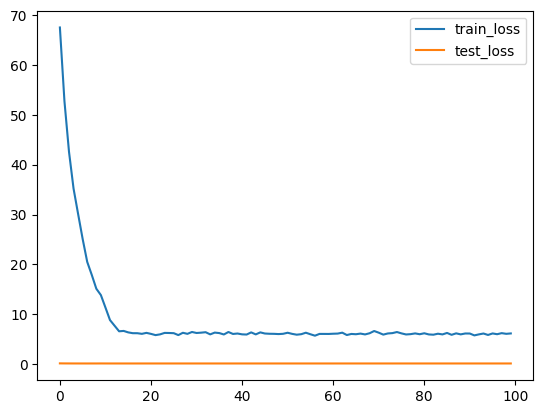

In [11]:

results = pd.DataFrame([])
results['train_loss']  = train_record
results['test_loss']  = test_record
results.plot.line(y=['train_loss', 'test_loss'])